## 1. Import Libraries

In [20]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string

# Transformers for IndoBERT
from transformers import BertTokenizer, BertModel
import torch

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# Warning
import warnings
warnings.filterwarnings('ignore')

print("Libraries berhasil diimport!")

Libraries berhasil diimport!


## 2. Load Data

In [2]:
# Load dataset
df = pd.read_csv('../Data/oplosan_train.csv')

print(f"Total data: {len(df)}")
print(f"\nKolom yang tersedia: {df.columns.tolist()}")
print(f"\nInfo dataset:")
df.info()

Total data: 4024

Kolom yang tersedia: ['author', 'comment', 'sentiment', 'positive_score', 'negative_score', 'sentiment_score', 'channel', 'title']

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   author           4024 non-null   object
 1   comment          4024 non-null   object
 2   sentiment        4024 non-null   object
 3   positive_score   4024 non-null   int64 
 4   negative_score   4024 non-null   int64 
 5   sentiment_score  4024 non-null   int64 
 6   channel          4024 non-null   object
 7   title            4024 non-null   object
dtypes: int64(3), object(5)
memory usage: 251.6+ KB


In [3]:
# Tampilkan beberapa baris pertama
df.head(10)

,author,comment,sentiment,positive_score,negative_score,sentiment_score,channel,title
0,Affanzero369,Loalah td subuh q habis ngisi disitu...... Tp ...,netral,0,0,0,Weezy Official,BENSIN VIRAL BIKIN MESIN BREBET!
1,heryyanto631,lha polisi urusan juga sidak pertalite emang m...,netral,0,0,0,Fokus Indosiar,Warga Tuban Keluhkan Pertalite Bikin Motor Mog...
2,batmanfilm0131,"Pertamax rasa Pertalite, Pertalite rasa Oplosan",netral,0,0,0,tvOneNews,"Viral Motor Mogok Gegara Pertalite, Pihak Pert..."
3,rickyhadiwijaya3826,Mau ngadu aja persyaratannya ribet bikin orang...,negatif,1,3,-2,KOMPASTV,"Kasus Pertalite Diduga Bercampur Air, Pertamin..."
4,kad1994,Mbk jgan bli bensin BPJS ngpain nyusahin dri s...,negatif,0,1,-1,Weezy Official,BENSIN VIRAL BIKIN MESIN BREBET!
5,setiawan485,Coba dari jatim mas,netral,0,0,0,Rustanto Autoinfo,"Percobaan Ke-3, PERTAMAX dan PERTALITE apakah ..."
6,SupriHartono-p4h,PANGGUNG SANDIWARA,netral,0,0,0,CNN Indonesia,"Motor Mogok Massal Usai Isi Pertalite, Pertami..."
7,SetofikSetofik,Pejabat pertamina sedang melakukan penipuan tr...,negatif,0,1,-1,Tribunnews,"Motor Brebet Karena BBM Bercampur di Surabaya,..."
8,NajmosabahSoba,Demo dong ke pom bensin,negatif,0,1,-1,Harian Kompas,Motor di Jawa Timur Mogok Massal Usai Isi Pert...
9,sumantomanto4521,Rakyat gak ada benarnya walaupun di rugikan,netral,0,0,0,tvOneNews,"Viral Motor Mogok Gegara Pertalite, Pihak Pert..."


## 3. Exploratory Data Analysis (EDA)

In [4]:
# Distribusi sentimen
print("Distribusi Sentimen:")
print(df['sentiment'].value_counts())
print(f"\nPersentase:")
print(df['sentiment'].value_counts(normalize=True) * 100)

Distribusi Sentimen:
sentiment
netral     2709
negatif     967
positif     348
Name: count, dtype: int64

Persentase:
sentiment
netral     67.321074
negatif    24.030815
positif     8.648111
Name: proportion, dtype: float64


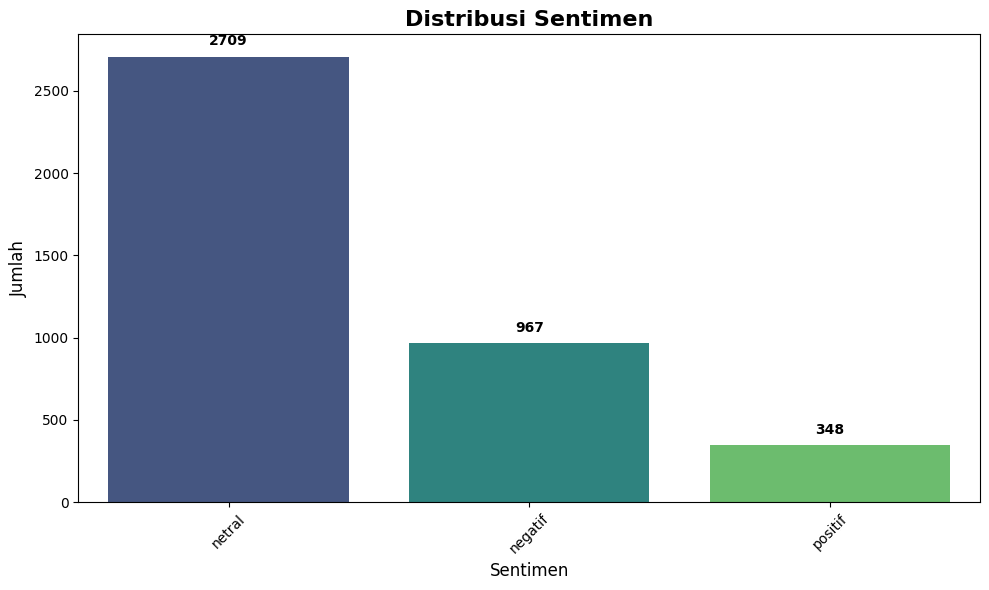

In [5]:
# Visualisasi distribusi sentimen
plt.figure(figsize=(10, 6))
sentiment_counts = df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribusi Sentimen', fontsize=16, fontweight='bold')
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45)

# Tambahkan nilai di atas bar
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
# Cek missing values
print("Missing Values:")
print(df.isnull().sum())

# Hapus baris dengan missing values di kolom 'comment' atau 'sentiment'
df = df.dropna(subset=['comment', 'sentiment'])
print(f"\nTotal data setelah menghapus missing values: {len(df)}")

Missing Values:
author             0
comment            0
sentiment          0
positive_score     0
negative_score     0
sentiment_score    0
channel            0
title              0
dtype: int64

Total data setelah menghapus missing values: 4024


## 4. Text Preprocessing

In [7]:
def preprocess_text(text):
    """
    Preprocessing text sederhana:
    - Lowercase
    - Hapus URL
    - Hapus mention (@username)
    - Hapus hashtag (#)
    - Hapus karakter khusus (kecuali spasi)
    - Hapus extra whitespace
    """
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Hapus mention
    text = re.sub(r'@\w+', '', text)
    
    # Hapus hashtag symbol (tapi simpan textnya)
    text = re.sub(r'#', '', text)
    
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    
    # Hapus punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Hapus extra whitespace
    text = ' '.join(text.split())
    
    return text

# Terapkan preprocessing
print("Melakukan preprocessing...")
df['cleaned_comment'] = df['comment'].apply(preprocess_text)

# Hapus komentar yang kosong setelah preprocessing
df = df[df['cleaned_comment'].str.strip() != '']
print(f"Total data setelah preprocessing: {len(df)}")

Melakukan preprocessing...
Total data setelah preprocessing: 4024


In [8]:
# Lihat contoh hasil preprocessing
print("Contoh hasil preprocessing:\n")
for idx in range(5):
    print(f"Original: {df.iloc[idx]['comment']}")
    print(f"Cleaned:  {df.iloc[idx]['cleaned_comment']}")
    print(f"Sentiment: {df.iloc[idx]['sentiment']}")
    print("-" * 80)

Contoh hasil preprocessing:

Original: Loalah td subuh q habis ngisi disitu...... Tp bukan pertaix tp Pertamax...... Soalnya gra2 pertaix mobilku JD boros. Mau ganti Shell kosong trs. Ya terpaksa Pertamax..... Mendingan sih JD perhitungan ku bukan patokan 1 liter banding berapa tp 100k JD 100km lebih..... Dripada pertaix isi 100k km nya cuma 80km....... Efek Bahlul anjink
Cleaned:  loalah td subuh q habis ngisi disitu tp bukan pertaix tp pertamax soalnya gra pertaix mobilku jd boros mau ganti shell kosong trs ya terpaksa pertamax mendingan sih jd perhitungan ku bukan patokan liter banding berapa tp k jd km lebih dripada pertaix isi k km nya cuma km efek bahlul anjink
Sentiment: netral
--------------------------------------------------------------------------------
Original: lha polisi urusan juga sidak pertalite emang mereka tau
Cleaned:  lha polisi urusan juga sidak pertalite emang mereka tau
Sentiment: netral
---------------------------------------------------------------------------

## 5. Prepare Data untuk Modeling

In [9]:
# Encode label sentimen
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

print("Label encoding:")
for label, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded}")

# Pisahkan fitur dan target
X = df['cleaned_comment'].values
y = df['sentiment_encoded'].values

# Split data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nJumlah data training: {len(X_train)}")
print(f"Jumlah data validation: {len(X_val)}")

Label encoding:
negatif: 0
netral: 1
positif: 2

Jumlah data training: 3219
Jumlah data validation: 805


## 6. Load IndoBERT Model

In [10]:
# Load IndoBERT tokenizer dan model
model_name = 'indobenchmark/indobert-base-p1'

print(f"Loading IndoBERT model: {model_name}")
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Set model ke evaluation mode
model.eval()

# Cek apakah GPU tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model loaded successfully!")
print(f"Device: {device}")

Loading IndoBERT model: indobenchmark/indobert-base-p1


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Model loaded successfully!
Device: cpu


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## 7. Extract Features dengan IndoBERT

In [11]:
def get_bert_embeddings(texts, batch_size=16):
    """
    Ekstrak embeddings dari IndoBERT untuk list of texts.
    Menggunakan [CLS] token sebagai representasi kalimat.
    """
    embeddings = []
    
    # Process dalam batch
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize
        encoded = tokenizer(
            batch_texts.tolist() if isinstance(batch_texts, np.ndarray) else batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        
        # Move to device
        encoded = {key: val.to(device) for key, val in encoded.items()}
        
        # Get embeddings
        with torch.no_grad():
            outputs = model(**encoded)
            # Gunakan [CLS] token (first token) sebagai sentence embedding
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embeddings.cpu().numpy())
    
    # Concatenate semua batch
    return np.vstack(embeddings)

print("Fungsi ekstraksi embedding siap!")

Fungsi ekstraksi embedding siap!


In [12]:
# Ekstrak embeddings untuk training data
print("Ekstrak embeddings untuk training data...")
X_train_embeddings = get_bert_embeddings(X_train, batch_size=16)
print(f"Shape X_train_embeddings: {X_train_embeddings.shape}")

Ekstrak embeddings untuk training data...


Extracting embeddings: 100%|██████████| 202/202 [02:38<00:00,  1.27it/s]

Shape X_train_embeddings: (3219, 768)


In [13]:
# Ekstrak embeddings untuk validation data
print("Ekstrak embeddings untuk validation data...")
X_val_embeddings = get_bert_embeddings(X_val, batch_size=16)
print(f"Shape X_val_embeddings: {X_val_embeddings.shape}")

Ekstrak embeddings untuk validation data...


Extracting embeddings: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s]

Shape X_val_embeddings: (805, 768)


## 8. Training SVM Classifier

In [14]:
# Train SVM dengan kernel RBF
print("Training SVM classifier...")
svm_classifier = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    verbose=True
)

svm_classifier.fit(X_train_embeddings, y_train)
print("Training selesai!")

Training SVM classifier...
[LibSVM]Training selesai!


## 9. Evaluasi Model

In [15]:
# Prediksi pada training data
y_train_pred = svm_classifier.predict(X_train_embeddings)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("=" * 60)
print("TRAINING SET PERFORMANCE")
print("=" * 60)
print(f"Accuracy: {train_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=label_encoder.classes_))

TRAINING SET PERFORMANCE
Accuracy: 0.8208

Classification Report:
              precision    recall  f1-score   support

     negatif       0.89      0.58      0.71       774
      netral       0.80      0.99      0.89      2167
     positif       1.00      0.19      0.33       278

    accuracy                           0.82      3219
   macro avg       0.90      0.59      0.64      3219
weighted avg       0.84      0.82      0.79      3219



In [16]:
# Prediksi pada validation data
y_val_pred = svm_classifier.predict(X_val_embeddings)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("=" * 60)
print("VALIDATION SET PERFORMANCE")
print("=" * 60)
print(f"Accuracy: {val_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

VALIDATION SET PERFORMANCE
Accuracy: 0.7901

Classification Report:
              precision    recall  f1-score   support

     negatif       0.84      0.51      0.63       193
      netral       0.78      0.98      0.87       542
     positif       1.00      0.11      0.21        70

    accuracy                           0.79       805
   macro avg       0.87      0.53      0.57       805
weighted avg       0.81      0.79      0.75       805



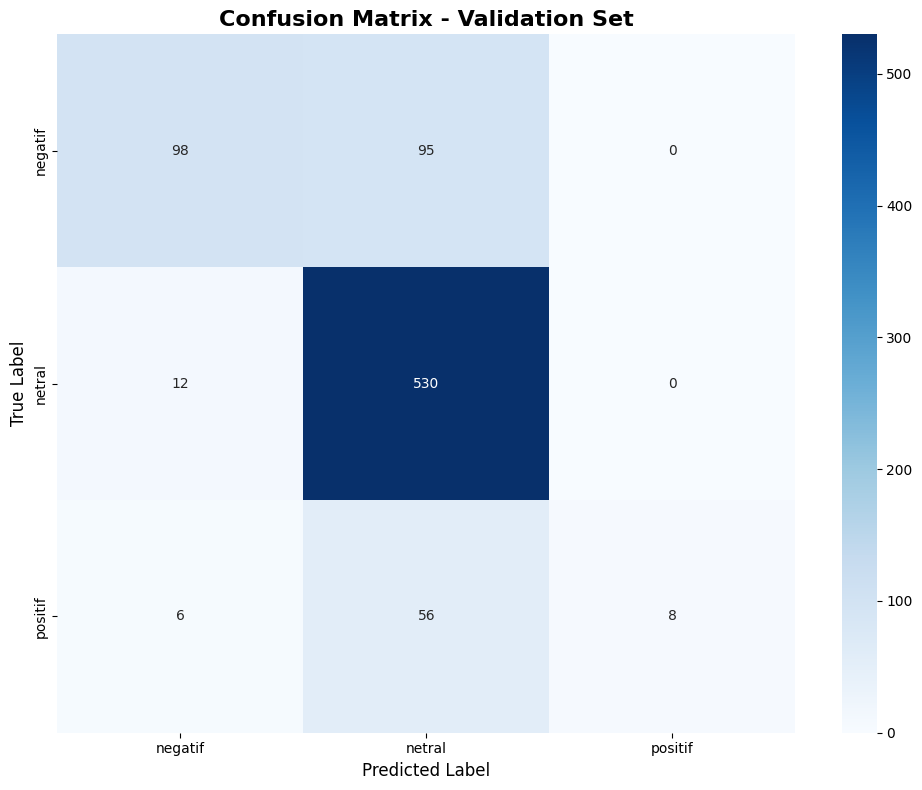

In [17]:
# Confusion Matrix untuk validation set
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## 10. Analisis Error

In [18]:
# Cari prediksi yang salah
incorrect_indices = np.where(y_val != y_val_pred)[0]

print(f"Total prediksi salah: {len(incorrect_indices)}")
print(f"Persentase error: {len(incorrect_indices) / len(y_val) * 100:.2f}%")

# Tampilkan beberapa contoh error
print("\n" + "=" * 80)
print("CONTOH PREDIKSI YANG SALAH:")
print("=" * 80)

for idx in incorrect_indices[:10]:  # Tampilkan 10 contoh pertama
    true_label = label_encoder.inverse_transform([y_val[idx]])[0]
    pred_label = label_encoder.inverse_transform([y_val_pred[idx]])[0]
    
    print(f"\nKomentar: {X_val[idx]}")
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred_label}")
    print("-" * 80)

Total prediksi salah: 169
Persentase error: 20.99%

CONTOH PREDIKSI YANG SALAH:

Komentar: bahlil bedes gk punya malu kerja gagal sbgai mntri klo djepang bunuh diri atau mundur dri jabatantpi emng indonesia tdk punya malu harga diri lemah dlm apapun
True Label: negatif
Predicted: netral
--------------------------------------------------------------------------------

Komentar: motor ku pun berebut apa salah ku aku tak merugikn orang lain
True Label: negatif
Predicted: netral
--------------------------------------------------------------------------------

Komentar: dari pemerintahnya minyaknya rakyatnya jalanrayanya duitnya dan lain² lagi semuanya huru hara hahaha konohakonohaindonesia emas jadi indonesia lemas ubahlah mentaliti anda semua jika mahu maju ke depan
True Label: positif
Predicted: netral
--------------------------------------------------------------------------------

Komentar: jelas tidak ada lah air di tengki pom pertamina orang sudah di isikan kekendaraan kok baru disid

## 11. Fine-tuning BERT Classifier

Sekarang kita akan membandingkan SVM dengan BERT classifier yang di-fine-tune.

In [22]:
# Custom Dataset untuk BERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Custom Dataset class siap!")

NameError: name 'Dataset' is not defined

In [ ]:
# Prepare DataLoader
batch_size = 16

# Gunakan tokenizer yang sama
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_length=128)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

In [ ]:
# Load BERT model untuk sequence classification
num_labels = len(label_encoder.classes_)

bert_model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

bert_model.to(device)

print(f"BERT Classifier loaded successfully!")
print(f"Number of labels: {num_labels}")
print(f"Device: {device}")

In [ ]:
# Setup optimizer dan scheduler
epochs = 3
learning_rate = 2e-5

optimizer = AdamW(bert_model.parameters(), lr=learning_rate, eps=1e-8)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Epochs: {epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Total training steps: {total_steps}")

In [ ]:
# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
        
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    
    return correct_predictions.double() / total_predictions, np.mean(losses)

print("Training function siap!")

In [ ]:
# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)
            
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return (correct_predictions.double() / total_predictions, 
            np.mean(losses), 
            np.array(all_preds), 
            np.array(all_labels))

print("Evaluation function siap!")

In [ ]:
# Training loop
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

print("=" * 80)
print("MULAI TRAINING BERT CLASSIFIER")
print("=" * 80)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 80)
    
    train_acc, train_loss = train_epoch(
        bert_model,
        train_loader,
        optimizer,
        scheduler,
        device
    )
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    val_acc, val_loss, _, _ = eval_model(bert_model, val_loader, device)
    
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    history['train_acc'].append(train_acc.cpu().numpy())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu().numpy())
    history['val_loss'].append(val_loss)

print("\n" + "=" * 80)
print("TRAINING SELESAI!")
print("=" * 80)

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='o')
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Evaluasi BERT Classifier

In [ ]:
# Evaluasi BERT pada validation set
bert_val_acc, bert_val_loss, bert_y_val_pred, bert_y_val_true = eval_model(
    bert_model, val_loader, device
)

print("=" * 60)
print("BERT CLASSIFIER - VALIDATION SET PERFORMANCE")
print("=" * 60)
print(f"Accuracy: {bert_val_acc:.4f}")
print(f"Loss: {bert_val_loss:.4f}")
print("\nClassification Report:")
print(classification_report(bert_y_val_true, bert_y_val_pred, target_names=label_encoder.classes_))

In [ ]:
# Confusion Matrix untuk BERT
cm_bert = confusion_matrix(bert_y_val_true, bert_y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_bert, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix - BERT Classifier', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## 13. Perbandingan Performa: BERT vs SVM

In [ ]:
# Hitung metrik untuk kedua model
svm_acc = accuracy_score(y_val, y_val_pred)
svm_f1_macro = f1_score(y_val, y_val_pred, average='macro')
svm_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

bert_acc = accuracy_score(bert_y_val_true, bert_y_val_pred)
bert_f1_macro = f1_score(bert_y_val_true, bert_y_val_pred, average='macro')
bert_f1_weighted = f1_score(bert_y_val_true, bert_y_val_pred, average='weighted')

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({
    'Model': ['SVM (IndoBERT Embeddings)', 'BERT Classifier'],
    'Accuracy': [svm_acc, bert_acc],
    'F1-Score (Macro)': [svm_f1_macro, bert_f1_macro],
    'F1-Score (Weighted)': [svm_f1_weighted, bert_f1_weighted]
})

print("=" * 80)
print("PERBANDINGAN PERFORMA MODEL")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

In [ ]:
# Visualisasi perbandingan
metrics = ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)']
svm_scores = [svm_acc, svm_f1_macro, svm_f1_weighted]
bert_scores = [bert_acc, bert_f1_macro, bert_f1_weighted]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, svm_scores, width, label='SVM (IndoBERT Embeddings)', color='steelblue')
bars2 = ax.bar(x + width/2, bert_scores, width, label='BERT Classifier', color='forestgreen')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Performa: SVM vs BERT Classifier', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Perbandingan per-class performance
from sklearn.metrics import precision_recall_fscore_support

# SVM metrics per class
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred, labels=range(num_labels)
)

# BERT metrics per class
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    bert_y_val_true, bert_y_val_pred, labels=range(num_labels)
)

# Buat DataFrame per-class comparison
class_comparison = pd.DataFrame({
    'Class': label_encoder.classes_,
    'SVM Precision': svm_precision,
    'BERT Precision': bert_precision,
    'SVM Recall': svm_recall,
    'BERT Recall': bert_recall,
    'SVM F1': svm_f1,
    'BERT F1': bert_f1
})

print("\n" + "=" * 80)
print("PERBANDINGAN PER-CLASS PERFORMANCE")
print("=" * 80)
print(class_comparison.to_string(index=False))
print("=" * 80)

In [ ]:
# Visualisasi F1-Score per class
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(label_encoder.classes_))
width = 0.35

bars1 = ax.bar(x - width/2, svm_f1, width, label='SVM', color='steelblue')
bars2 = ax.bar(x + width/2, bert_f1, width, label='BERT', color='forestgreen')

ax.set_xlabel('Sentiment Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score per Sentiment Class: SVM vs BERT', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 14. Testing Kedua Model dengan Komentar Baru

In [ ]:
# Fungsi prediksi untuk BERT
def predict_sentiment_bert(text, model, tokenizer, device):
    """
    Prediksi sentimen menggunakan BERT classifier
    """
    model.eval()
    
    # Preprocessing
    cleaned_text = preprocess_text(text)
    
    # Tokenize
    encoding = tokenizer(
        cleaned_text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Prediksi
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, prediction = torch.max(logits, dim=1)
    
    sentiment = label_encoder.inverse_transform(prediction.cpu().numpy())[0]
    
    return sentiment, cleaned_text

print("Fungsi prediksi BERT siap!")

In [ ]:
# Test dengan beberapa komentar baru - bandingkan kedua model
test_comments = [
    "Bensin pertamina bagus sekali, motor saya jadi lancar",
    "Kecewa dengan kualitas pertalite, motor jadi mogok",
    "Harga BBM naik lagi nih",
    "Pelayanan SPBU sangat mengecewakan, antrian panjang",
    "Terima kasih pertamina, BBM berkualitas",
    "Motor saya brebet setelah isi pertalite",
    "Bagus, tidak ada masalah dengan BBM",
    "Pertamina harus bertanggung jawab atas kualitas BBM yang buruk"
]

print("=" * 100)
print("PERBANDINGAN PREDIKSI: SVM vs BERT")
print("=" * 100)

results = []
for comment in test_comments:
    # Prediksi SVM
    svm_sentiment, cleaned = predict_sentiment(comment)
    
    # Prediksi BERT
    bert_sentiment, _ = predict_sentiment_bert(comment, bert_model, tokenizer, device)
    
    results.append({
        'Komentar': comment,
        'Cleaned': cleaned,
        'SVM': svm_sentiment,
        'BERT': bert_sentiment,
        'Agreement': '✓' if svm_sentiment == bert_sentiment else '✗'
    })
    
    print(f"\nKomentar: {comment}")
    print(f"Cleaned: {cleaned}")
    print(f"SVM Prediction:  {svm_sentiment}")
    print(f"BERT Prediction: {bert_sentiment}")
    print(f"Agreement: {'✓ SAMA' if svm_sentiment == bert_sentiment else '✗ BEDA'}")
    print("-" * 100)

# Hitung agreement rate
agreement_count = sum(1 for r in results if r['Agreement'] == '✓')
agreement_rate = agreement_count / len(results) * 100

print(f"\nAgreement Rate: {agreement_count}/{len(results)} ({agreement_rate:.1f}%)")
print("=" * 100)

## 15. Kesimpulan & Analisis

In [ ]:
# Summary perbandingan
print("=" * 80)
print("SUMMARY PERBANDINGAN MODEL")
print("=" * 80)
print("\n📊 METRIK PERFORMA:")
print(f"   SVM (IndoBERT Embeddings):")
print(f"   - Accuracy: {svm_acc:.4f}")
print(f"   - F1-Score (Macro): {svm_f1_macro:.4f}")
print(f"   - F1-Score (Weighted): {svm_f1_weighted:.4f}")
print(f"\n   BERT Classifier:")
print(f"   - Accuracy: {bert_acc:.4f}")
print(f"   - F1-Score (Macro): {bert_f1_macro:.4f}")
print(f"   - F1-Score (Weighted): {bert_f1_weighted:.4f}")

# Tentukan model terbaik
if bert_acc > svm_acc:
    diff = (bert_acc - svm_acc) * 100
    print(f"\n🏆 WINNER: BERT Classifier lebih baik {diff:.2f}% dalam accuracy")
elif svm_acc > bert_acc:
    diff = (svm_acc - bert_acc) * 100
    print(f"\n🏆 WINNER: SVM lebih baik {diff:.2f}% dalam accuracy")
else:
    print(f"\n🤝 TIE: Kedua model memiliki accuracy yang sama")

print("\n" + "=" * 80)
print("KARAKTERISTIK MODEL:")
print("=" * 80)
print("\n✓ SVM (IndoBERT Embeddings):")
print("  + Lebih cepat dalam inference (hanya perlu forward pass untuk embedding)")
print("  + Model lebih ringan (hanya SVM classifier + frozen BERT)")
print("  + Tidak perlu fine-tuning BERT (hemat waktu training)")
print("  - Tidak dapat menyesuaikan representasi BERT untuk task spesifik")

print("\n✓ BERT Classifier (Fine-tuned):")
print("  + Dapat menyesuaikan representasi untuk task spesifik")
print("  + Potensial performa lebih baik dengan tuning yang tepat")
print("  - Membutuhkan waktu training lebih lama")
print("  - Model lebih besar (perlu save seluruh BERT)")
print("  - Membutuhkan lebih banyak GPU memory")

print("\n" + "=" * 80)

In [ ]:
def predict_sentiment(text):
    """
    Prediksi sentimen untuk text baru
    """
    # Preprocessing
    cleaned_text = preprocess_text(text)
    
    # Get embedding
    embedding = get_bert_embeddings(np.array([cleaned_text]), batch_size=1)
    
    # Prediksi
    prediction = svm_classifier.predict(embedding)
    sentiment = label_encoder.inverse_transform(prediction)[0]
    
    return sentiment, cleaned_text

# Test dengan beberapa komentar baru
test_comments = [
    "Bensin pertamina bagus sekali, motor saya jadi lancar",
    "Kecewa dengan kualitas pertalite, motor jadi mogok",
    "Harga BBM naik lagi nih",
    "Pelayanan SPBU sangat mengecewakan, antrian panjang",
    "Terima kasih pertamina, BBM berkualitas"
]

print("=" * 80)
print("TESTING DENGAN KOMENTAR BARU")
print("=" * 80)

for comment in test_comments:
    sentiment, cleaned = predict_sentiment(comment)
    print(f"\nKomentar: {comment}")
    print(f"Cleaned: {cleaned}")
    print(f"Sentimen: {sentiment}")
    print("-" * 80)